In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
ls *load*

biomag_download_info.ipynb  download_hcp_central.ipynb  download_output.txt


In [3]:
ls /mnt/hcp-meg/105923/

rest-run0-preproc-raw.fif  rest-run1-preproc-raw.fif  rest-run2-preproc-raw.fif


In [4]:
import copy as cp
import os.path as op
import mne

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

import hcp
from hcp import preprocessing as preproc
from hcp import io

from scipy.signal import welch
import numpy as np

from sklearn.linear_model import LinearRegression

In [5]:
sns.set_style('ticks')

In [6]:
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
# matplotlib.rc('text', usetex='false') 

In [7]:
recordings_path = '/mnt/hcp-meg'
subject = '105923'

In [8]:
fname = op.join(recordings_path, subject, 'rest-run0-preproc-raw.fif')

In [9]:
raw = mne.io.read_raw_fif(fname)

Opening raw data file /mnt/hcp-meg/105923/rest-run0-preproc-raw.fif...
Isotrak not found
    Range : 0 ... 749069 =      0.000 ...   368.182 secs
Ready.
Current compensation grade : 0
Annotation expanding outside the data range. Limiting to the end of data.


<ipython-input-9-826c3e305aa6>:1: RuntimeWarning: Annotation expanding outside the data range. Limiting to the end of data.
  raw = mne.io.read_raw_fif(fname)


In [10]:
raw.load_data()

Reading 0 ... 749069  =      0.000 ...   368.182 secs...


<Raw  |  rest-run0-preproc-raw.fif, n_channels x n_times : 248 x 749070 (368.2 sec), ~1.38 GB, data loaded>

In [12]:
%matplotlib inline

In [13]:
def _preprocess_raw(raw, hcp_params, ica_sel):
    # construct MNE annotations
    annots = hcp.read_annot(**hcp_params)
    bad_seg = (annots['segments']['all']) / raw.info['sfreq']
    annotations = mne.Annotations(
        bad_seg[:, 0], (bad_seg[:, 1] - bad_seg[:, 0]),
        description='bad')

    raw.annotations = annotations
    raw.info['bads'] += annots['channels']['all']
    raw.pick_types(meg=True, ref_meg=False)

    # read ICA and remove EOG ECG or keep brain components
    ica_mat = hcp.read_ica(**hcp_params)
    if ica_sel == 'ecg_eog':
        exclude = annots['ica']['ecg_eog_ic']
    elif ica_sel == 'brain':
        exclude = [ii for ii in range(annots['ica']['total_ic_number'][0])
                   if ii not in annots['ica']['brain_ic_vs']]

    preproc.apply_ica_hcp(raw, ica_mat=ica_mat, exclude=exclude)
    # add back missing channels
    raw = preproc.interpolate_missing(raw, **hcp_params)
    return raw

In [73]:
hcp_params = dict(subject=subject, hcp_path=op.join('/mnt', 'HCP'),
                  data_type='rest')

raw = _preprocess_raw(raw, hcp_params=hcp_params, ica_sel='ecg_eog')

Reading 4D PDF file /mnt/HCP/105923/unprocessed/MEG/3-Restin/4D/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Creating RawArray with float64 data, n_channels=248, n_times=749070
Current compensation grade : 0
    Range : 0 ... 749069 =      0.000 ...   368.182 secs
Ready.
    Computing dot products for 245 coils...
    Computing cross products for coils 245 x 3 coils...
    Preparing the mapping matrix...
    [Truncate at 84 missing 0.0001]


## works with with natural log

6.24416690066


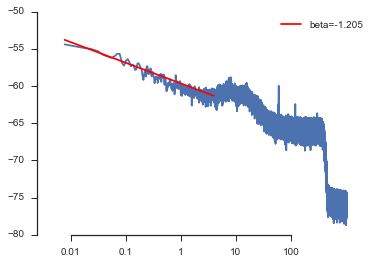

In [13]:
%matplotlib inline
freqs, psd = welch(raw[100][0], nperseg=(2**18), fs=raw.info['sfreq'], detrend='linear')
fmask = (freqs <= 4) & (freqs > 0)
lm = LinearRegression(normalize=False).fit(
   np.log(freqs[fmask][:, None]),
   np.log(psd.T[fmask]),
   )
frange = np.log(freqs[fmask].max()) - np.log(freqs[fmask].min())
print(frange)
plt.figure()
plt.plot(np.log(freqs), np.log(psd.T))
plt.plot(np.log(freqs[fmask][[0, -1]]),
         np.array([lm.intercept_,
                   lm.intercept_ + lm.coef_ * frange]) + frange, color='red',
         label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log([0.01, 0.1, 1, 10, 100]),
                  [0.01, 0.1, 1, 10, 100])
sns.despine(trim=True)

## works with with decadic log

In [231]:
freqs, psd = welch(raw[100][0] * 1e15, nperseg=(2**18), fs=raw.info['sfreq'], detrend='linear', scaling='density')
    

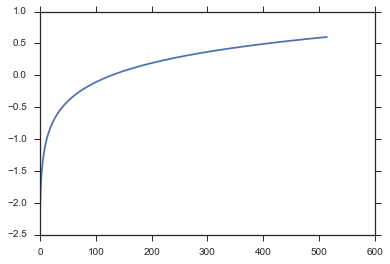

In [244]:
plt.plot(freqs[fmask])

In [1]:
freqs, psd = welch(raw[100][0], nperseg=(2**15), fs=raw.info['sfreq'], detrend='linear',
                   scaling='spectrum', noverlap=0)
fmask = (freqs <= 4) & (freqs > 0)
fmask = (freqs <= 4) & (freqs > 0)
freqs = np.log10(freqs)
psd /= psd[:, 1]
psd = 20 * np.log10(psd)
lm = LinearRegression(normalize=False).fit(
   freqs[fmask][:, None],
   psd.T[fmask])

fit_line = lm.predict(freqs[fmask][:, None])
plt.figure()
plt.plot(freqs, psd.T)
plt.plot(freqs[fmask], fit_line, color='red', label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
sns.despine(trim=True)

NameError: name 'welch' is not defined

## beta estimates as a function of window length

In [16]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

In [17]:
mean_squared_error(lm.predict(np.log10(freqs[fmask])[:, None]), np.log10(psd.T[fmask]))

0.061303147406198959

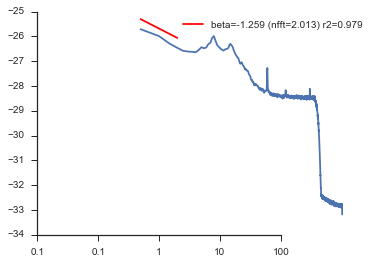

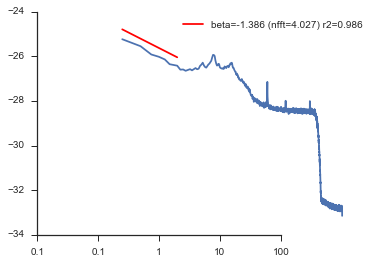

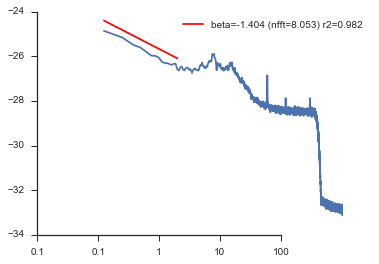

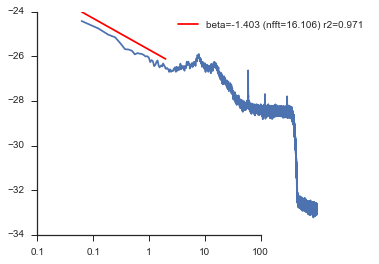

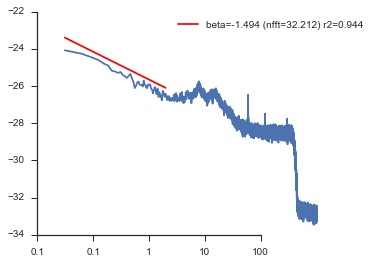

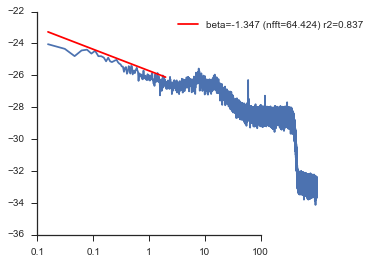

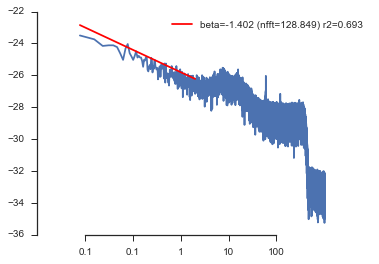

In [156]:
for exp in [12, 13, 14, 15, 16, 17, 18]:
    n_fft = 2 ** exp
    freqs, psd = welch(raw[100][0], nperseg=(n_fft), fs=raw.info['sfreq'], detrend='constant',
                       noverlap=0)
    fmask = (freqs <= 2) & (freqs > 0)
    lm = LinearRegression(normalize=False).fit(
       np.log10(freqs[fmask][:, None]),
       np.log10(psd.T[fmask]),
       )
    score = r2_score(
        lm.predict(np.log10(freqs[fmask])[:, None]), np.log10(psd.T[fmask]))
    frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
    plt.figure()
    plt.plot(np.log10(freqs), np.log10(psd.T))
    fit_line = (lm.intercept_ - lm.coef_ * frange), lm.intercept_
    plt.plot(np.log10(freqs[fmask][[0, -1]]),
             fit_line, color='red',
             label='beta=%0.3f (nfft=%0.3f) r2=%0.3f' % (
                lm.coef_[0], 1. / raw.info['sfreq'] * n_fft, score))
    plt.legend(loc='best')
    plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
    sns.despine(trim=True)
    

## Use FFT without windowing

In [157]:
(lm.intercept_ - (lm.coef_ * frange)), lm.intercept_

(array([[-22.84542378]]), array([-26.22300673]))

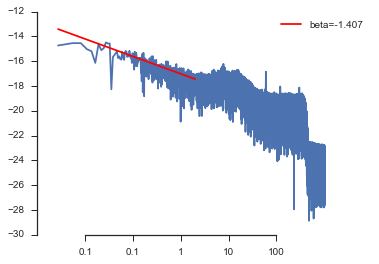

In [141]:
from scipy import fft, fftpack

freqs = fftpack.fftfreq(len(raw[100][0][0]), raw.times[1] - raw.times[0])
freqs = freqs[:freqs.size/2]

psd = fftpack.fft(raw[100][0][0])
psd = np.abs(psd[:psd.size/2][None, :])

fmask = (freqs <= 2) & (freqs > 0)
lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]),
   np.log10(psd.T[fmask]),
   )
frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
plt.figure()
plt.plot(np.log10(freqs), np.log10(psd.T))

fit_line = np.array([lm.intercept_,
                     lm.intercept_ + lm.coef_ * frange])
offset = np.abs(np.diff(fit_line.ravel()))[0]
plt.plot(np.log10(freqs[fmask][[0, -1]]),
         fit_line + offset, color='red',
         label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
sns.despine(trim=True)  

## an improved welch estimator

Use epoching functionality to get the good data segments, then apply windowing manually prior to FFT computation.
Shortcut: drop bad epochs, reconstruct raw data and then use the scipy function.

We see that with zero overlap the solutions are equivalent

In [182]:
n_fft = 2**15
duration = n_fft * (1. / raw.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True)

22 matching events found
No baseline correction applied
0 projection items activated
Loading data for 22 events and 32769 original time points ...
9 bad epochs dropped


In [183]:
raw2 = mne.io.RawArray(info=epochs.info, data=np.hstack(epochs.get_data()))

Creating RawArray with float64 data, n_channels=248, n_times=425997
Current compensation grade : 0
    Range : 0 ... 425996 =      0.000 ...   209.385 secs
Ready.


In [184]:
print(raw.times.shape, raw2.times.shape)

((749070,), (425997,))


In [185]:
psd1, freqs = mne.time_frequency.psd_welch(raw, n_fft=n_fft, picks=[100], n_overlap=0)
psd2, freqs = mne.time_frequency.psd_welch(raw2, n_fft=n_fft, picks=[100], n_overlap=0)
psd3_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, picks=[100], n_overlap=0)
psd3 = psd3_epochs.mean(0)

Effective window size : 16.106 (s)
Effective window size : 16.106 (s)
Effective window size : 16.106 (s)


In [186]:
ls paper_figures/

check_nfft_power_spectrum.png  check_welch_estimators_power.png
check_welch_estimators.png     paper_fig_beta_est_choice.png


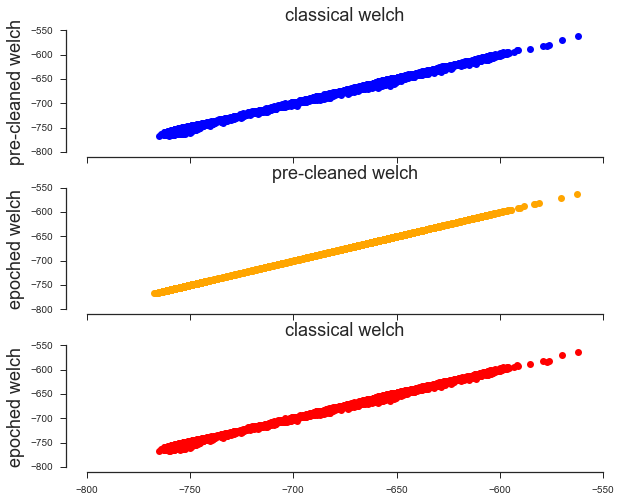

In [187]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

fs = 18
axs[0].plot(10 * np.log(psd1.ravel()), 10 * np.log(psd2.ravel()),
            linewidth=0, marker='o', color='blue')
axs[0].set_title('classical welch', fontsize=fs)
axs[0].set_ylabel('pre-cleaned welch', fontsize=fs)

axs[1].plot(10 * np.log(psd3.ravel()), 10 * np.log(psd2.ravel()),
            linewidth=0, marker='o', color='orange')
axs[1].set_title('pre-cleaned welch', fontsize=fs)
axs[1].set_ylabel('epoched welch', fontsize=fs)

axs[2].plot(10 * np.log(psd1.ravel()), 10 * np.log(psd3.ravel()),
            linewidth=0, marker='o', color='red')

axs[2].set_title('classical welch', fontsize=fs)
axs[2].set_ylabel('epoched welch', fontsize=fs)
for ax in axs:
    ax.set_xlim(-810, -540)
    ax.set_ylim(-810, -540)
sns.despine(trim=True)

plt.show()
fig.savefig('paper_figures/check_welch_estimators.png', dpi=600)

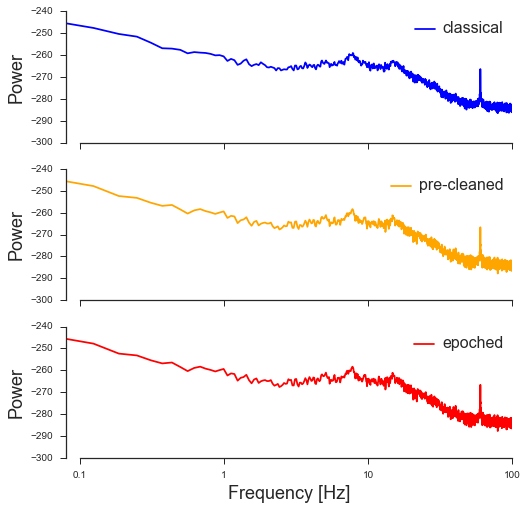

In [188]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

fs = 18
axs[0].plot(np.log10(freqs), 10 * np.log10(psd1).T, label='classical', color='blue')
axs[1].plot(np.log10(freqs), 10 * np.log10(psd2).T, label='pre-cleaned', color='orange')
axs[2].plot(np.log10(freqs), 10 * np.log10(psd3).T, label='epoched', color='red')
[[l.set_fontsize(16) for l in ax.legend().get_texts()] for ax in axs]
for ii, ax in enumerate(axs):
    if ii == 2:
        ax.set_xlabel('Frequency [Hz]', fontsize=fs)
    ax.set_ylabel('Power', fontsize=fs)
    ax.set_xticks(np.log10([0.1, 1, 10, 100]))
    ax.set_xticklabels([0.1, 1, 10, 100])
    ax.set_ylim(-300, -240)
    ax.set_xlim(np.log10(0.08), np.log10(100))

sns.despine(trim=True)
fig.savefig('paper_figures/check_welch_estimators_power.png', dpi=600)

In [122]:
lm.coef_.mean()

-15.24649941645662

In [124]:
lm.intercept_.mean(), (lm.intercept_.mean() + lm.coef_.mean() * frange) + frange

(-260.80670611188879, -290.82707171482872)

In [113]:
np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())

2.1072099696478683

In [123]:
np.log10(freqs[fmask].max() - freqs[fmask].min())

0.29475365164425188

In [127]:
fit_line = np.array([lm.intercept_.mean(),
                         lm.intercept_.mean() + lm.coef_.mean() * frange])

In [168]:
np.log10(freqs[fmask])

array([-0.30390009, -0.0028701 ,  0.17322116,  0.2981599 ])

182 matching events found
No baseline correction applied
0 projection items activated
Loading data for 182 events and 4097 original time points ...
40 bad epochs dropped
Effective window size : 2.013 (s)
91 matching events found
No baseline correction applied
0 projection items activated
Loading data for 91 events and 8193 original time points ...
23 bad epochs dropped
Effective window size : 4.027 (s)
45 matching events found
No baseline correction applied
0 projection items activated
Loading data for 45 events and 16385 original time points ...
14 bad epochs dropped
Effective window size : 8.053 (s)
22 matching events found
No baseline correction applied
0 projection items activated
Loading data for 22 events and 32769 original time points ...
9 bad epochs dropped
Effective window size : 16.106 (s)
11 matching events found
No baseline correction applied
0 projection items activated
Loading data for 11 events and 65537 original time points ...
7 bad epochs dropped
Effective window siz

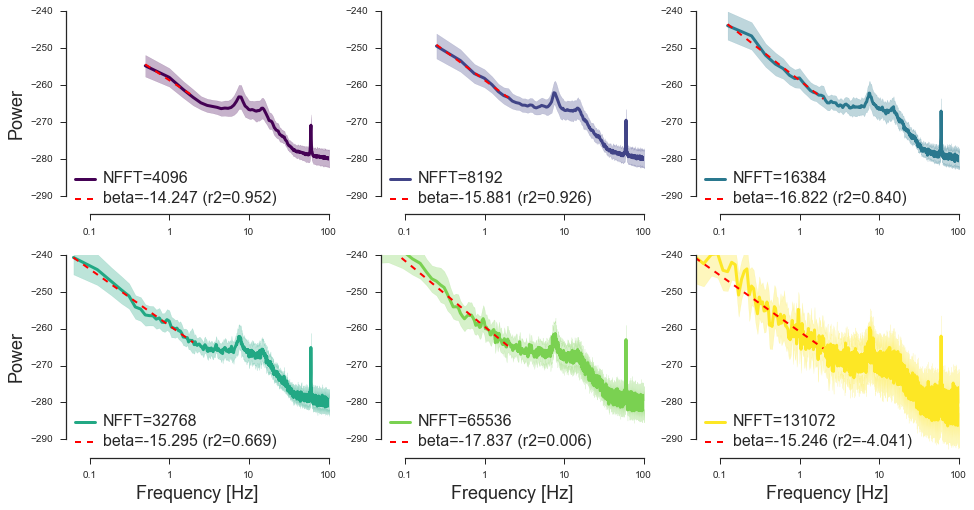

In [189]:
vals = list()

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel()

colors = [plt.cm.viridis(ii) for ii in
          np.linspace(0, 1, len(axes))]

for i_ax, (exp, ax, color) in enumerate(zip(
        [12, 13, 14, 15, 16, 17], axes, colors)):
    n_fft = 2 ** exp
    duration = n_fft * (1. / raw.info['sfreq'])
    events = mne.make_fixed_length_events(raw, 42, duration=duration)
    epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                        tmax=duration, baseline=None, preload=True)
    psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
    psd = 10 * np.log10(psd_epochs.mean(0))
    
    fmask = (freqs <= 2) & (freqs > 0)
    frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
    
    lm = LinearRegression(normalize=False).fit(
       np.log10(freqs[fmask][:, None]), psd.T[fmask])
    scores = [r2_score(x, y) for x, y in zip(
              lm.predict(np.log10(freqs[fmask])[:, None]), psd.T[fmask])]
    vals.append((n_fft, scores, lm.coef_.ravel(), freqs[fmask][0]))
    psd_std = psd.std(0).T
    psd_mean = psd.mean(0).T
    
    ax.fill_between(np.log10(freqs), (psd_mean + psd_std).ravel(),
                                     (psd_mean - psd_std).ravel(),
                    color=color, alpha=0.3)
    ax.plot(np.log10(freqs), psd_mean, color=color,
            label='NFFT={}'.format(n_fft), linewidth=3)

    fit_line = lm.predict(np.log10(freqs[fmask][:, None])).mean(1)
    ax.plot(np.log10(freqs[fmask]),
             fit_line, color='red',
             label='beta=%0.3f (r2=%0.3f)' % (
                lm.coef_.mean(), np.mean(scores)),
            linewidth=2, linestyle='--')
    if i_ax in [3, 4, 5]:
        ax.set_xlabel('Frequency [Hz]', fontsize=18)
    if i_ax in [0, 3]:
        ax.set_ylabel('Power', fontsize=18)
    ax.set_xticks(np.log10([0.1, 1, 10, 100]))
    ax.set_xticklabels([0.1, 1, 10, 100])
    ax.set_xlim(np.log10(0.05), np.log10(100))
    ax.set_ylim(-295, -240)
    for tt in ax.legend(loc='lower left').get_texts():
        tt.set_fontsize(16)


sns.despine(trim=True)
fig.savefig('paper_figures/check_nfft_power_spectrum.png', dpi=600)

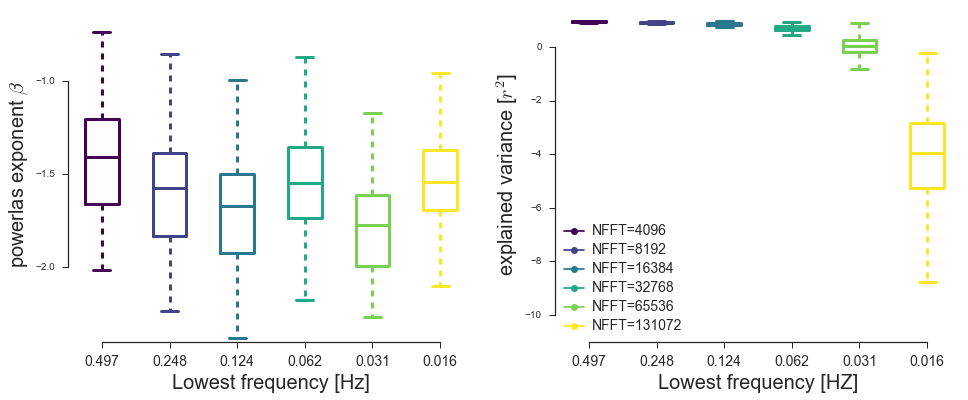

In [1034]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

bplots = [axs[0].boxplot([v[2] for v in vals]),
          axs[1].boxplot([v[1] for v in vals])]
axs[0].set_xticklabels([v[3].round(3) for v in vals], fontsize=14)
axs[1].set_xticklabels([v[3].round(3) for v in vals], fontsize=14)
axs[0].set_xlabel('Lowest frequency [Hz]', fontsize=20)
axs[1].set_xlabel('Lowest frequency [HZ]', fontsize=20)
axs[0].set_ylabel(r'powerlas exponent $\beta$ ', fontsize=20)
axs[1].set_ylabel(r'explained variance [$r^2$]', fontsize=20)
axs[0].set_xlim(0.5, 6.5)
axs[1].set_xlim(0.5, 6.5)
axs[1].set_ylim(-11, 1.5)


all_colors = [[plt.cm.viridis(ii) for ii in
               np.linspace(0, 1, len(vals))],
              [plt.cm.viridis(ii) for ii in
               np.linspace(0, 1, len(vals))]]

[axs[1].plot(42, 42, label='NFFT=%d' % v[0], color=c, marker='o')
 for v, c in zip(vals, all_colors[1])]
lg = axs[1].legend(loc='best')
[tt.set_fontsize(14) for tt in lg.get_texts()]

for bb, bplot in enumerate(bplots, 0):
    colors = all_colors[bb]
    for k, elems in bplot.items():
        for jj, el in enumerate(elems):
            if len(elems) == len(colors):
                this_colors = colors[:]
            else:
                this_colors = sum([[c, c] for c in colors], [])
            if hasattr(el, 'set_color'):
                el.set_color(this_colors[jj])
                el.set_linewidth(3)
sns.despine(trim=True)

fig.savefig('paper_figures/paper_fig_beta_est_choice.png', dpi=600)

## Checkout source localization and beta estimation

The firt task here will be to map the broadband signalfrom which we extract slow cortical potentials and the bandpass filtered hilbert alpha time course into source space such that memory does not explode and the corresponding powerlaw exponent can be computed.

We can stick with our epochs estimator here and map data epoch by epoch into the source space to then aggregate the data. Once this is done we can estimate powerlaw exponents all over the cortex without ROI-based approach.

The procedure is the same, whether we use the broadband data ore hilbert transformed data.
In the latter case the inverse operator will be applied to complex valued raw data.

### some concerns

- regularization parameter can have a strong impact on power estimates using MNE, the spatial SNR can be effectively much better than snr=1. Range 1-15 to be considered.
- covariance: frequency specific noise ... should probably match the signal projected.


In [1057]:
raw_noise = hcp.read_raw(data_type='noise_empty_room', subject='105923', hcp_path='/mnt/HCP')

Reading 4D PDF file /mnt/HCP/105923/unprocessed/MEG/1-Rnoise/4D/c,rfDC...
Creating Neuromag info structure ...
... Setting channel info structure.
... no headshape file supplied, doing nothing.
Currently direct inclusion of 4D weight tables is not supported. For critical use cases please take into account the MNE command "mne_create_comp_data" to include weights as printed out by the 4D "print_table" routine.
Current compensation grade : 0


In [1035]:
from scipy.signal.spectral import get_window

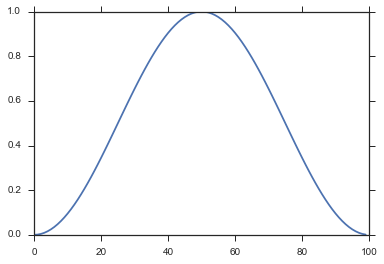

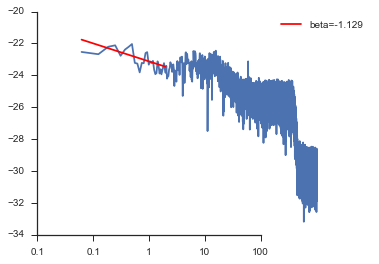

In [1049]:
from scipy import fft, fftpack

x = raw[100][0][0]
n_samples = x.shape[-1]
# win = get_window('hanning', n_samples)

psd = fftpack.fft(x, n=2**15)

n_samples = psd.shape[-1]
freqs = fftpack.fftfreq(psd.shape[-1], raw.times[1] - raw.times[0])
psd = np.abs(psd[:psd.size/2][None, :]) ** 2
freqs = freqs[:freqs.size/2]

fmask = (freqs <= 2) & (freqs > 0)
lm = LinearRegression(normalize=False).fit(
   np.log10(freqs[fmask][:, None]),
   np.log10(psd.T[fmask]),
   )
frange = np.log10(freqs[fmask].max()) - np.log10(freqs[fmask].min())
plt.figure()
plt.plot(np.log10(freqs), np.log10(psd.T))
plt.plot(np.log10(freqs[fmask][[0, -1]]),
         np.array([lm.intercept_,
                   lm.intercept_ + lm.coef_ * frange]) + frange, color='red',
         label='beta=%0.3f' % lm.coef_[0])
plt.legend(loc='best')
plt.xticks(np.log10([0.01, 0.1, 1, 10, 100]), [0.1, 0.1, 1, 10, 100])
sns.despine(trim=True)  

## check how filter params drive alpha envelope slope

In [2]:
ls

aws_details.csv                        mse-0-150-rh.stc
aws_hcp_details.csv                    output.txt
biomag_download_info.ipynb             paper_check_powerlaw_fit.ipynb
biomag_figures/                        paper_fig_beta_est_choice.png
biomag_pilot_analysis_sensor.ipynb     paper_figures/
biomag_poster_sensor.ipynb             par_output_lm_fit.txt
biomag_single_subject.py               pilot_biomag_source_space.ipynb
biomag_single_subject.pyc              plot_alpha_1overf.py
coefs-0-150-lh.stc                     plot_figure_one.ipynb
coefs-0-150-rh.stc                     plot_figures_two.ipynb
compute_hcp_check_bads_power.py        power-0-150_label_tcs.npy
config.py                              power-0-150-lh.stc
download_hcp_central.ipynb             power-0-150-rh.stc
download_output.txt                    run_compute_alpha_1overf.py
explore_figures_one.ipynb              run_compute_psds.py
hcp_compute_mne_anatomy.py             run_errors.txt
hcp_compute_subject_bads_

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 7 - 13 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 3.2 Hz
Filter length of 6714 samples (3.300 sec) selected
22 matching events found
No baseline correction applied
0 projection items activated
Loading data for 22 events and 32769 original time points ...
9 bad epochs dropped
Effective window size : 16.106 (s)
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up band-pass filter from 8 - 12 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 3.0 Hz
Filter length of 6714 samples (3.300 sec) selected
22 matching events found
No baseline correction applied
0 projection items activated
Loading data for 22 events and 32769 original time points ...
9 bad epochs dropped
Effective window size : 16.106 (s)
Filtering a subset of channels. The 

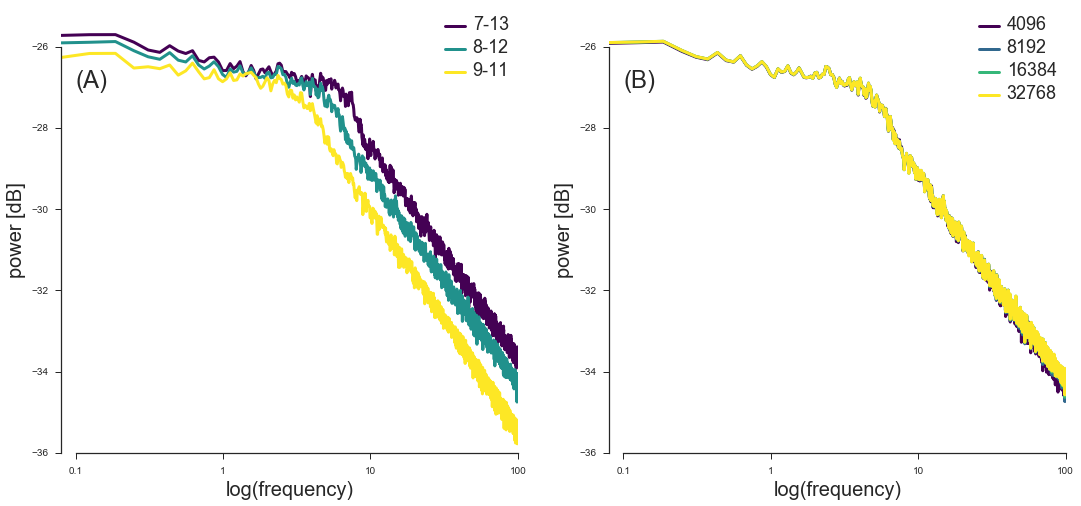

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.ravel()
n_fft = 2 ** 15
filtparams = [(7, 13), (8, 12), (9, 11)]
colors = [plt.cm.viridis(cc) for cc in np.linspace(0, 1, len(filtparams))] 
for ii, (fmin, fmax) in enumerate(filtparams):
    raw_hil = raw.copy().filter(fmin, fmax, picks=[100])
    raw_hil.apply_hilbert(picks=[100], envelope=True)
    freqs, psd = welch(raw_hil[100][0], nperseg=(n_fft), fs=raw_hil.info['sfreq'],
                       detrend='constant',
                       noverlap=0)
    duration = n_fft * (1. / raw.info['sfreq'])
    events = mne.make_fixed_length_events(raw, 42, duration=duration)
    epochs = mne.Epochs(raw_hil, events=events, event_id=42, tmin=0, picks=[100],
                        tmax=duration, baseline=None, preload=True)
    psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
    psd = psd_epochs.mean(0)
    axes[0].plot(np.log10(freqs), np.log10(psd.T),
                 color=colors[ii], label='{}-{}'.format(fmin, fmax), linewidth=3);
ax = axes[0]
for tt in ax.legend(loc='best').get_texts():
    tt.set_fontsize(18)
ax.set_xlabel('log(frequency)', fontsize=20)
ax.set_ylabel('power [dB]', fontsize=20)
ax.annotate('(A)', xy=(np.log10(0.1), -27), fontsize=24)
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
ax.set_xlim(np.log10(0.08), np.log10(100))

ax.set_ylim(-36, -25)

filtparams = [12, 13, 14, 15]
colors = [plt.cm.viridis(cc) for cc in np.linspace(0, 1, len(filtparams))] 
for ii, (exp) in enumerate(filtparams):
    raw_hil = raw.copy().filter(l_freq=8, h_freq=12, filter_length=2 ** exp, picks=[100])
    raw_hil.apply_hilbert(picks=[100], envelope=True)
    freqs, psd = welch(raw_hil[100][0], nperseg=(n_fft), fs=raw_hil.info['sfreq'],
                       detrend='constant',
                       noverlap=0)

    duration = n_fft * (1. / raw.info['sfreq'])
    events = mne.make_fixed_length_events(raw, 42, duration=duration)
    epochs = mne.Epochs(raw_hil, events=events, event_id=42, tmin=0, picks=[100],
                        tmax=duration, baseline=None, preload=True)
    psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
    psd = psd_epochs.mean(0)
    axes[1].plot(np.log10(freqs), np.log10(psd.T),
                 color=colors[ii], label='{}'.format(2**exp), linewidth=3);
ax = axes[1]
for tt in ax.legend(loc='best').get_texts():
    tt.set_fontsize(18)
ax.set_xlabel('log(frequency)', fontsize=20)
ax.set_ylabel('power [dB]', fontsize=20)
ax.set_xticks(np.log10([0.1, 1, 10, 100]))
ax.set_xticklabels([0.1, 1, 10, 100])
ax.set_xlim(np.log10(0.08), np.log10(100))
ax.set_ylim(-36, -25)
ax.annotate('(B)', xy=(np.log10(0.1), -27), fontsize=24)
sns.despine(trim=True)
fig.savefig('paper_figures/check_filter_params_on_alpha.png', dpi=600)

# Checkout peak estimation with kernels an diff trick

In [15]:
n_fft = 2 ** 15
duration = n_fft * (1. / raw.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True)


22 matching events found
No baseline correction applied
0 projection items activated
Loading data for 22 events and 32769 original time points ...
9 bad epochs dropped


In [16]:
from astropy.convolution import convolve, Gaussian1DKernel

In [28]:
np.log10(psd)

array([[-23.2477974 ,          nan,          nan, ..., -31.71244619,
                 nan,          nan],
       [-22.89850007,          nan,          nan, ..., -31.47930334,
                 nan,          nan],
       [-23.57557522,          nan,          nan, ..., -31.97330759,
                 nan,          nan],
       ..., 
       [-23.15916314,          nan,          nan, ..., -31.68673546,
                 nan,          nan],
       [-22.77572065,          nan,          nan, ..., -32.00421975,
                 nan,          nan],
       [-22.31022709,          nan,          nan, ...,          nan,
        -31.35680263,          nan]])

In [44]:
(smoothed_data_gauss.T.shape, freqs.shape)

((16384, 248), (16385,))

In [74]:
n_fft = 2 ** 15
duration = n_fft * (1. / raw.info['sfreq'])
events = mne.make_fixed_length_events(raw, 42, duration=duration)
epochs = mne.Epochs(raw, events=events, event_id=42, tmin=0,
                    tmax=duration, baseline=None, preload=True)

psd_epochs, freqs = mne.time_frequency.psd_welch(epochs, n_fft=n_fft, n_overlap=0)
# psd = 10 * np.diff(np.log10(psd_epochs.mean(0)), 1, axis=-1)
# psd = 10 * np.diff(psd_epochs.mean(0), 1, axis=-1)
# psd = 10 * np.log10(psd_epochs.mean(0))
# gauss_kernel = Gaussian1DKernel(np.sum(freqs < 1))  # 0.5 Hz bandwidth

# smoothed_data_gauss = np.array([convolve(pp, gauss_kernel) for pp in psd])
# smoothed_data_gauss = convolve(psd[100], gauss_kernel)
# plt.plot(np.log10(freqs[1:]), psd.T, color='red')
# plt.plot(np.log10(freqs[1:],
#          smoothed_data_gauss.T, color='blue', alpha=0.01)
# plt.xlim(*np.log10([1, 50]))
# plt.xticks(np.log10([0.1, 1, 10]), [0.1, 1, 10])

22 matching events found
No baseline correction applied
0 projection items activated
Loading data for 22 events and 32769 original time points ...
9 bad epochs dropped
Effective window size : 16.106 (s)


2


(1, 30)

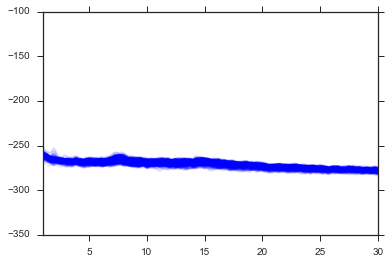

In [91]:
psd = 10 * np.log10(psd_epochs).mean(0)
k = np.sum(freqs < 0.1)
# k = 5
print(k)
gauss_kernel = Gaussian1DKernel(k)  # 0.5 Hz bandwidth
# smoothed_data_gauss = np.array([convolve(pp, gauss_kernel) for pp in np.diff(psd, axis=-1)])
smoothed_data_gauss = np.array([convolve(pp, gauss_kernel) for pp in psd])

plt.plot(freqs,
         smoothed_data_gauss.T, color='blue', alpha=.1);
plt.xlim([1, 30])
# plt.xlim(*np.log10([1, 100]))
# plt.xticks(np.log10([0.1, 1, 10, 100]), [0.1, 1, 10, 100])

In [35]:
smoothed_data_gauss[:, freqs < 200]

array([[-132.10493955, -143.46100399, -154.65167666, ..., -279.54073207,
        -279.56321894, -279.58233808],
       [-130.77036116, -142.01806301, -153.10383487, ..., -278.24739803,
        -278.26415744, -278.27999125],
       [-132.16050047, -143.45713546, -154.57612261, ..., -281.82521681,
        -281.87797018, -281.929901  ],
       ..., 
       [-131.69407648, -142.98655845, -154.10960523, ..., -280.51298374,
        -280.56497007, -280.61815523],
       [-130.54320749, -141.7581487 , -152.81044111, ..., -279.78598438,
        -279.81304292, -279.84477538],
       [-128.18401958, -139.26911665, -150.20803777, ..., -277.00146349,
        -276.97803369, -276.955911  ]])

Failed to locate mag channel positions from layout. Inferring channel positions from data.


<ipython-input-49-c1b724da46d7>:7: RuntimeWarning: Failed to locate mag channel positions from layout. Inferring channel positions from data.
  unit='Hz', size=4, contours=0);


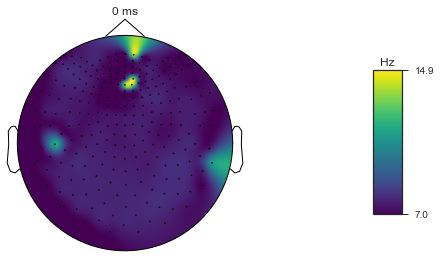

In [49]:
fmask = (freqs < 15) * (freqs > 7)
peaks = np.array([freqs[fmask][ii] for ii in
                  np.argmax(smoothed_data_gauss[:, fmask], 1)])
peaks = mne.EvokedArray(info=cp.deepcopy(raw.info), data=peaks[:, None], tmin=0)
hcp.preprocessing.map_ch_coords_to_mne(peaks)
peaks.plot_topomap([0], scale=1, cmap='viridis', vmin=np.min, vmax=np.max,
                   unit='Hz', size=4, contours=0);

# Try whitening

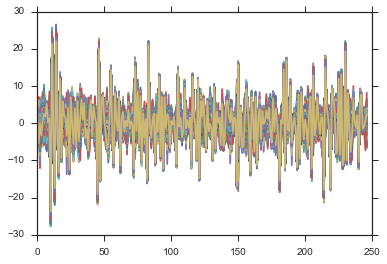

In [12]:
from mne.time_frequency import fit_iir_model_raw
from scipy import signal

In [13]:
x = raw[100][0][0].ravel()
order = 5
b, a = fit_iir_model_raw(raw, order=order, picks=[100])

In [21]:
innovation = signal.convolve(x, a, 'valid')
# x_ = np.r_[x_[0] * np.intones(order), x_]  # dummy samples to keep signal length

In [ ]:
x_ = signal.lfilter(x, a, innovation)  # regenerate the signal

In [18]:
x_

(4995,)